# TF-MoDISco on the TAL GATA simulation

This notebook demonstrates running TF-MoDISco on importance scores obtained from the TAL-GATA simulation used in the DeepLIFT paper. See `Generate Importance Scores.ipynb` for a notebook demonstrating how to produce the scores. There are 3 tasks. Task 0 is positive when both TAL and GATA motifs are present in the sequence. Task 1 is positive when GATA motifs are present in the sequence. Task 2 is positive when TAL motifs are present in the sequence.

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
print (sys.version)
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "4"

TF-MoDISco is using the TensorFlow backend.


3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


### Functions for one-hot encoding sequences

In [3]:
import gzip

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [4]:
import h5py
from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) for x in f['contrib_scores'][task][:]]
    task_to_hyp_scores[task] = [np.array(x) for x in f['hyp_contrib_scores'][task][:]]

onehot_data = [one_hot_encode_along_channel_axis(seq) for seq in fasta_sequences]
fwd_activations = f['activations/fwd']
rev_activations = f['activations/rev']
#pad the activations
left_pad = int((len(onehot_data[0]) - fwd_activations.shape[1])/2)
right_pad = int(np.ceil(len(onehot_data[0]) - fwd_activations.shape[1])/2)
padded_fwd_activations = np.concatenate(
    [np.zeros((fwd_activations.shape[0], left_pad, fwd_activations.shape[-1])),
      fwd_activations,
      np.zeros((fwd_activations.shape[0], right_pad, fwd_activations.shape[-1]))], axis=1)
padded_rev_activations = np.concatenate(
    [np.zeros((rev_activations.shape[0], right_pad, rev_activations.shape[-1])),
      rev_activations,
      np.zeros((rev_activations.shape[0], left_pad, rev_activations.shape[-1]))], axis=1)

Double check by plotting

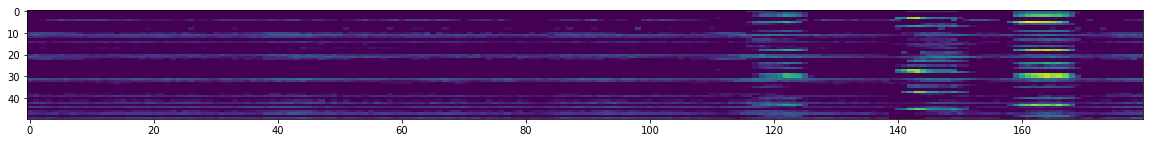

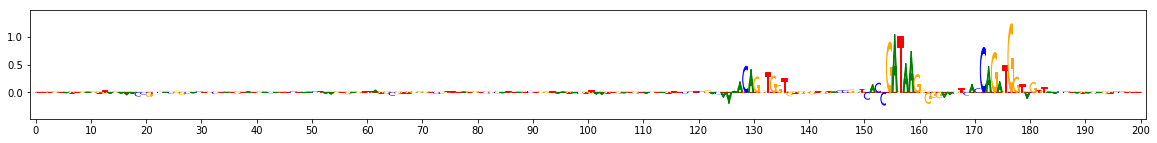

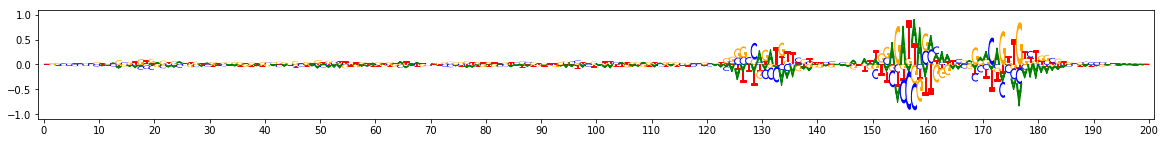

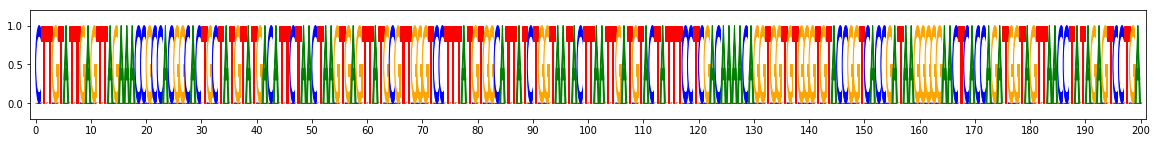

In [5]:
import modisco.visualization
from modisco.visualization import viz_sequence
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(20, 2))
ax.imshow(fwd_activations[0].transpose(1,0))
ax.set_aspect('auto')
plt.show()
viz_sequence.plot_weights(task_to_scores['task0'][0], subticks_frequency=10)
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0], subticks_frequency=10)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=10)


## Run TF-MoDISco

TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. Since there are 3 tasks, there are 27 possible metaclusters (consisting of a +1, -1 or 0 for each task). Consistent with the simulation, the [+1, +1, 0], [+1, 0, +1], [0, 0, +1] and [0, +1, 0] metaclusters turn up motifs.

To demonstrate customization, the code below has slight modifications from default settings in the following ways:
- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central `trim_to_window_size` bp with the highest importance. `trim_to_window_size` is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by `initial_flank_to_add`. This is set to 3 rather than the default of 10.
- The `final_min_cluster_size` is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 60 seqlets).
- It uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage on the GPU down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, and this works fine on more modern GPUs than the one in my 4-year-old macbook.
- `target_seqlet_fdr` controls the noisiness of the seqlets. For a particular task, "significant" seqlets are identified by first smoothing importance scores with a window of size `sliding_window_size` and then fitting a laplace distribution to the left and right tails. This laplace distribution is assumed to represent the null distribution of window importance scores (note: as an alternative, it's possible to supply an empirical null distribution; see `examples/H1ESC_Nanog_gkmsvm/TF MoDISco Nanog.ipynb` for an example). A threshold is then identified such that the false discovery rate (computed as the ratio of the expected fraction of windows with a certain score in the null distribution relative to the observed fraction of windows with that score) is less that `target_seqlet_fdr`. Note: if the number of sliding windows that pass the FDR threshold is smaller than `min_passing_windows_frac` (default value 0.03 at the time of writing) or larger than `max_passing_windows_frac` (default value of 0.2 at the time of writing), the threshold will be adjusted.

On task task0
Computing windowed sums on original
Generating null dist


TF-MoDISco is using the TensorFlow backend.


peak(mu)= -0.013692386905662716
Computing threshold
Thresholds from null dist were -1.6740694046020508  and  1.0749762058258057
Final raw thresholds are -1.6740694046020508  and  1.0749762058258057
Final transformed thresholds are -0.891505376344086  and  0.8522513440860215


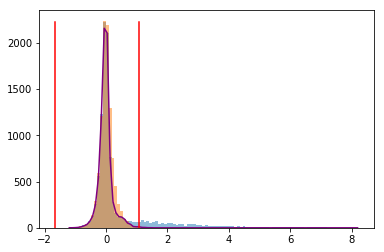

Got 1477 coords
On task task1
Computing windowed sums on original
Generating null dist
peak(mu)= 0.007673137664794921
Computing threshold
Thresholds from null dist were -1.7263836562633514  and  0.6461410522460938
Final raw thresholds are -1.7263836562633514  and  0.6461410522460938
Final transformed thresholds are -0.9206317204301075  and  0.8848185483870967


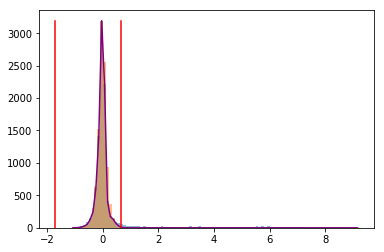

Got 1133 coords
On task task2
Computing windowed sums on original
Generating null dist
peak(mu)= 0.00609868049621582
Computing threshold
Thresholds from null dist were -0.6546361446380615  and  0.7163791656494141
Final raw thresholds are -0.6546361446380615  and  0.7163791656494141
Final transformed thresholds are -0.875752688172043  and  0.8803427419354839


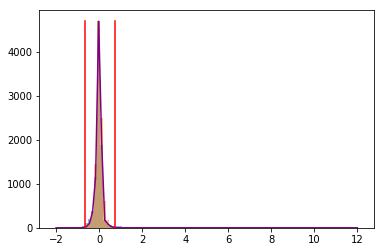

Got 1248 coords
After resolving overlaps, got 2166 seqlets
Across all tasks, the weakest transformed threshold used was: 0.8522512440860216
2166 identified in total
6 activity patterns with support >= 100 out of 27 possible patterns
Metacluster sizes:  [705, 689, 312, 129, 127, 109]
Idx to activities:  {0: '1,0,1', 1: '1,1,0', 2: '1,1,1', 3: '0,1,-1', 4: '0,1,0', 5: '0,0,-1'}
On metacluster 5
Metacluster size 109
Relevant tasks:  ('task2',)
Relevant signs:  (-1,)
Will use ['activations']  to make the affinity matrix instead of the gappedkmer embedder + finegrained affmat
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 109
(Round 1) Computing affmat
Beginning embedding computation
Computing embedding from  ['activations']
Finished embedding computation in 0.0 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.0 s
(Round 1) Computing density adapted affmat
[t-SNE] C

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  60 tasks      | elapsed:    5.9s


Louvain completed 200 runs in 7.344448804855347 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    7.3s finished


Wrote graph to binary file in 0.03312993049621582 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.762233
Louvain completed 51 runs in 1.0499351024627686 seconds
Preproc + Louvain took 8.49534010887146 s
Got 7 clusters after round 1
Counts:
{2: 18, 6: 9, 1: 19, 3: 16, 0: 22, 5: 11, 4: 14}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 22 seqlets
Trimmed 0 out of 22
Aggregating for cluster 1 with 19 seqlets
Trimmed 0 out of 19
Skipped 2 seqlets
Aggregating for cluster 2 with 18 seqlets
Trimmed 3 out of 18
Dropping cluster 2 with 15 seqlets due to sign disagreement
Aggregating for cluster 3 with 16 seqlets
Trimmed 0 out of 16
Skipped 3 seqlets
Aggregating for cluster 4 with 14 seqlets
Trimmed 0 out of 14
Skipped 2 seqlets
Aggregating for cluster 5 with 11 seqlets
Trimmed 0 out of 11
Skipped 1 seqlets
Aggregating for cluster 6 with 9 seqlets
Trimmed 0 out of 9
Dropping cluster 6 with 9 seqlets due to sign disagreement


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Louvain completed 200 runs in 1.9927423000335693 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.0s finished


Wrote graph to binary file in 0.020576953887939453 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.763613
Louvain completed 51 runs in 1.0323429107666016 seconds
Preproc + Louvain took 3.1113381385803223 s
Got 6 clusters after round 2
Counts:
{4: 10, 1: 16, 3: 14, 0: 17, 2: 15, 5: 2}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 17 seqlets
Trimmed 0 out of 17
Aggregating for cluster 1 with 16 seqlets
Trimmed 0 out of 16
Aggregating for cluster 2 with 15 seqlets
Trimmed 4 out of 15
Aggregating for cluster 3 with 14 seqlets
Trimmed 1 out of 14
Aggregating for cluster 4 with 10 seqlets
Trimmed 0 out of 10
Aggregating for cluster 5 with 2 seqlets
Trimmed 0 out of 2
Got 6 clusters
Splitting into subclusters...
Merging on 6 clusters
On merging iteration 1
Computing pattern to seqlet distances
Computing pattern to pattern distances
Got 6 patterns after merging
Performing seqlet reassignment
Got 0 patterns after reassignm

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Louvain completed 200 runs in 2.1059131622314453 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.1s finished


Wrote graph to binary file in 0.03613901138305664 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.765511
Louvain completed 51 runs in 1.0375399589538574 seconds
Preproc + Louvain took 3.2689971923828125 s
Got 7 clusters after round 1
Counts:
{3: 19, 2: 25, 4: 16, 6: 8, 5: 9, 1: 25, 0: 25}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 25 seqlets
Trimmed 0 out of 25
Skipped 6 seqlets
Aggregating for cluster 1 with 25 seqlets
Trimmed 4 out of 25
Skipped 3 seqlets
Aggregating for cluster 2 with 25 seqlets
Trimmed 1 out of 25
Aggregating for cluster 3 with 19 seqlets
Trimmed 0 out of 19
Skipped 4 seqlets
Aggregating for cluster 4 with 16 seqlets
Trimmed 0 out of 16
Skipped 3 seqlets
Aggregating for cluster 5 with 9 seqlets
Trimmed 0 out of 9
Aggregating for cluster 6 with 8 seqlets
Trimmed 0 out of 8
(Round 2) num seqlets: 106
(Round 2) Computing affmat
Beginning embedding computation
Computing embedding from  ['activa

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Louvain completed 200 runs in 2.058652877807617 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.0s finished


Wrote graph to binary file in 0.02474379539489746 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.723663
Louvain completed 51 runs in 0.9705173969268799 seconds
Preproc + Louvain took 3.1350626945495605 s
Got 5 clusters after round 2
Counts:
{4: 13, 1: 27, 3: 13, 0: 29, 2: 24}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 29 seqlets
Trimmed 4 out of 29
Aggregating for cluster 1 with 27 seqlets
Trimmed 11 out of 27
Aggregating for cluster 2 with 24 seqlets
Trimmed 2 out of 24
Skipped 1 seqlets
Aggregating for cluster 3 with 13 seqlets
Trimmed 1 out of 13
Aggregating for cluster 4 with 13 seqlets
Trimmed 4 out of 13
Skipped 1 seqlets
Got 5 clusters
Splitting into subclusters...
Merging on 5 clusters
On merging iteration 1
Computing pattern to seqlet distances
Computing pattern to pattern distances
Collapsing 0 & 2 with prob 0.0021716991726003906 and sim 0.9892401763073605
Collapsing 2 & 3 with prob 4.275977327790526

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Louvain completed 200 runs in 2.0089170932769775 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.0s finished


Wrote graph to binary file in 0.04119706153869629 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.787519
Louvain completed 51 runs in 1.1038708686828613 seconds
Preproc + Louvain took 3.2454988956451416 s
Got 6 clusters after round 1
Counts:
{5: 16, 1: 25, 3: 21, 2: 23, 0: 25, 4: 19}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 25 seqlets
Trimmed 4 out of 25
Skipped 1 seqlets
Aggregating for cluster 1 with 25 seqlets
Trimmed 3 out of 25
Skipped 4 seqlets
Aggregating for cluster 2 with 23 seqlets
Trimmed 0 out of 23
Aggregating for cluster 3 with 21 seqlets
Trimmed 0 out of 21
Skipped 2 seqlets
Aggregating for cluster 4 with 19 seqlets
Trimmed 0 out of 19
Skipped 1 seqlets
Aggregating for cluster 5 with 16 seqlets
Trimmed 0 out of 16
Skipped 1 seqlets
(Round 2) num seqlets: 113
(Round 2) Computing affmat
Beginning embedding computation
Computing embedding from  ['activations']
Finished embedding computation in 0.0

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Louvain completed 200 runs in 1.9935920238494873 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.0s finished


Wrote graph to binary file in 0.027626991271972656 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.733983
Louvain completed 51 runs in 1.089156150817871 seconds
Preproc + Louvain took 3.196265935897827 s
Got 6 clusters after round 2
Counts:
{2: 18, 1: 24, 0: 26, 3: 18, 4: 16, 5: 11}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 26 seqlets
Trimmed 2 out of 26
Aggregating for cluster 1 with 24 seqlets
Trimmed 0 out of 24
Aggregating for cluster 2 with 18 seqlets
Trimmed 0 out of 18
Aggregating for cluster 3 with 18 seqlets
Trimmed 3 out of 18
Aggregating for cluster 4 with 16 seqlets
Trimmed 1 out of 16
Aggregating for cluster 5 with 11 seqlets
Trimmed 0 out of 11
Got 6 clusters
Splitting into subclusters...
Merging on 6 clusters
On merging iteration 1
Computing pattern to seqlet distances
Computing pattern to pattern distances
Collapsing 3 & 4 with prob 1.4737609447885156e-06 and sim 1.9286611869275498
Collapsing 1

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Louvain completed 200 runs in 2.487150192260742 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.4s finished


Wrote graph to binary file in 0.12468600273132324 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.80044
Louvain completed 51 runs in 1.1262807846069336 seconds
Preproc + Louvain took 3.8977410793304443 s
Got 8 clusters after round 1
Counts:
{6: 20, 3: 46, 2: 53, 5: 31, 0: 55, 1: 54, 4: 36, 7: 17}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 55 seqlets
Trimmed 9 out of 55
Skipped 7 seqlets
Aggregating for cluster 1 with 54 seqlets
Trimmed 6 out of 54
Skipped 4 seqlets
Aggregating for cluster 2 with 53 seqlets
Trimmed 4 out of 53
Skipped 1 seqlets
Aggregating for cluster 3 with 46 seqlets
Trimmed 5 out of 46
Skipped 5 seqlets
Aggregating for cluster 4 with 36 seqlets
Trimmed 0 out of 36
Skipped 7 seqlets
Aggregating for cluster 5 with 31 seqlets
Trimmed 0 out of 31
Skipped 4 seqlets
Aggregating for cluster 6 with 20 seqlets
Trimmed 4 out of 20
Skipped 2 seqlets
Aggregating for cluster 7 with 17 seqlets
Trimmed 0 ou

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Louvain completed 200 runs in 2.2144439220428467 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.1s finished


Wrote graph to binary file in 0.0897219181060791 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.789992
After 5 runs, maximum modularity is Q = 0.799207
Louvain completed 55 runs in 1.2830562591552734 seconds
Preproc + Louvain took 3.712538957595825 s
Got 8 clusters after round 2
Counts:
{1: 37, 4: 32, 5: 30, 3: 35, 6: 21, 2: 35, 0: 48, 7: 13}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 48 seqlets
Trimmed 0 out of 48
Aggregating for cluster 1 with 37 seqlets
Trimmed 2 out of 37
Aggregating for cluster 2 with 35 seqlets
Trimmed 2 out of 35
Aggregating for cluster 3 with 35 seqlets
Trimmed 0 out of 35
Aggregating for cluster 4 with 32 seqlets
Trimmed 0 out of 32
Aggregating for cluster 5 with 30 seqlets
Trimmed 0 out of 30
Aggregating for cluster 6 with 21 seqlets
Trimmed 2 out of 21
Aggregating for cluster 7 with 13 seqlets
Trimmed 2 out of 13
Got 8 clusters
Splitting into subclusters...
Merging on 8 clusters
On 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.2s finished


Louvain completed 200 runs in 3.5840651988983154 seconds
Wrote graph to binary file in 0.8802869319915771 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.777694
After 40 runs, maximum modularity is Q = 0.789523
Louvain completed 90 runs in 2.3951120376586914 seconds
Preproc + Louvain took 7.155974864959717 s
Got 8 clusters after round 1
Counts:
{3: 87, 2: 96, 4: 84, 7: 62, 5: 74, 1: 103, 0: 119, 6: 64}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 119 seqlets
Trimmed 10 out of 119
Skipped 20 seqlets
Aggregating for cluster 1 with 103 seqlets
Trimmed 4 out of 103
Skipped 20 seqlets
Aggregating for cluster 2 with 96 seqlets
Trimmed 8 out of 96
Skipped 11 seqlets
Aggregating for cluster 3 with 87 seqlets
Trimmed 9 out of 87
Skipped 14 seqlets
Aggregating for cluster 4 with 84 seqlets
Trimmed 0 out of 84
Skipped 14 seqlets
Aggregating for cluster 5 with 74 seqlets
Trimmed 5 out of 74
Skipped 7 seqlets
Aggregating for 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Louvain completed 200 runs in 3.070908784866333 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.9s finished


Wrote graph to binary file in 0.5625710487365723 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.767694
After 2 runs, maximum modularity is Q = 0.768613
After 8 runs, maximum modularity is Q = 0.770318
After 15 runs, maximum modularity is Q = 0.772419
Louvain completed 65 runs in 1.602349042892456 seconds
Preproc + Louvain took 5.450155019760132 s
Got 10 clusters after round 2
Counts:
{1: 78, 7: 33, 4: 58, 0: 84, 9: 10, 8: 29, 3: 60, 5: 55, 6: 41, 2: 63}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 84 seqlets
Trimmed 1 out of 84
Aggregating for cluster 1 with 78 seqlets
Trimmed 8 out of 78
Aggregating for cluster 2 with 63 seqlets
Trimmed 0 out of 63
Aggregating for cluster 3 with 60 seqlets
Trimmed 1 out of 60
Aggregating for cluster 4 with 58 seqlets
Trimmed 0 out of 58
Aggregating for cluster 5 with 55 seqlets
Trimmed 3 out of 55
Aggregating for cluster 6 with 41 seqlets
Trimmed 5 out of 41
Aggregating for clu

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.2s finished


Louvain completed 200 runs in 3.666948080062866 seconds
Wrote graph to binary file in 1.0012767314910889 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.725245
After 3 runs, maximum modularity is Q = 0.7423
After 4 runs, maximum modularity is Q = 0.743909
After 10 runs, maximum modularity is Q = 0.754226
Louvain completed 60 runs in 1.9288902282714844 seconds
Preproc + Louvain took 6.885651111602783 s
Got 10 clusters after round 1
Counts:
{3: 80, 9: 18, 2: 93, 8: 48, 4: 62, 0: 131, 5: 58, 1: 100, 6: 58, 7: 57}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 131 seqlets
Trimmed 15 out of 131
Skipped 21 seqlets
Aggregating for cluster 1 with 100 seqlets
Trimmed 3 out of 100
Skipped 22 seqlets
Aggregating for cluster 2 with 93 seqlets
Trimmed 1 out of 93
Skipped 18 seqlets
Aggregating for cluster 3 with 80 seqlets
Trimmed 5 out of 80
Skipped 16 seqlets
Aggregating for cluster 4 with 62 seqlets
Trimmed 13 out of 62
Skip

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Louvain completed 200 runs in 3.408892869949341 seconds


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.2s finished


Wrote graph to binary file in 0.7395219802856445 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.731859
After 3 runs, maximum modularity is Q = 0.734934
After 18 runs, maximum modularity is Q = 0.752927
Louvain completed 68 runs in 1.865173101425171 seconds
Preproc + Louvain took 6.244195938110352 s
Got 10 clusters after round 2
Counts:
{6: 40, 0: 112, 1: 76, 8: 25, 2: 66, 9: 17, 4: 52, 3: 54, 7: 40, 5: 48}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 112 seqlets
Trimmed 7 out of 112
Aggregating for cluster 1 with 76 seqlets
Trimmed 0 out of 76
Aggregating for cluster 2 with 66 seqlets
Trimmed 0 out of 66
Aggregating for cluster 3 with 54 seqlets
Trimmed 0 out of 54
Aggregating for cluster 4 with 52 seqlets
Trimmed 3 out of 52
Aggregating for cluster 5 with 48 seqlets
Trimmed 1 out of 48
Aggregating for cluster 6 with 40 seqlets
Trimmed 3 out of 40
Aggregating for cluster 7 with 40 seqlets
Trimmed 0 out of 40
Agg

In [16]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.tensorflow_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)

activations_data_track = modisco.core.DataTrack(name="activations",
                           fwd_tracks=padded_fwd_activations,
                           rev_tracks=None,#padded_rev_activations,
                           has_pos_axis=True)
other_tracks = [activations_data_track]

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    target_seqlet_fdr=0.15,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=60,
                        tracknames_to_use_for_embedding=["activations"])
                )(
                task_names=["task0", "task1", "task2"],
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data,
                other_tracks=other_tracks,
                #In the TAL-GATA simulation I had not embedded the reverse-complements of
                # the motifs for ease of explanation to an ML audience. But this also
                # means that the convolutional filters cannot detect the reverse
                # complements of the motifs; hence, we set revcomp=False here.
                revcomp=False,
                )

## Save and print the results

In [17]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)

Metaclusters heatmap


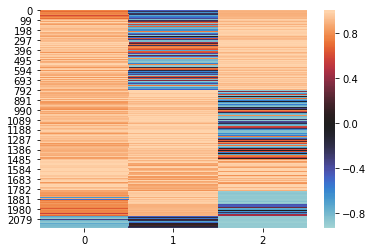

metacluster_0
activity pattern: [1 0 1]
metacluster_0 pattern_0
total seqlets: 479
activations


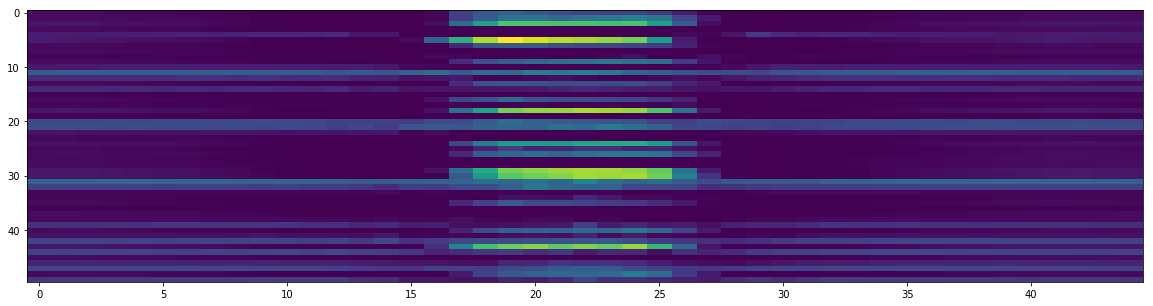

Task 0 hypothetical scores:


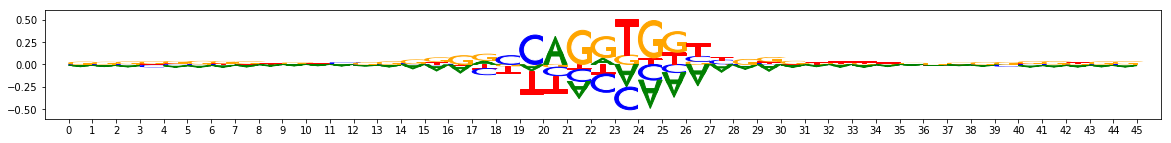

Task 0 actual importance scores:


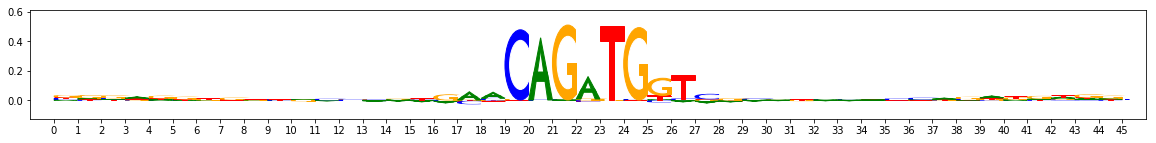

Task 1 hypothetical scores:


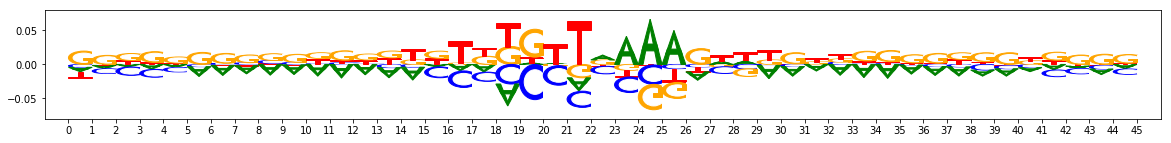

Task 1 actual importance scores:


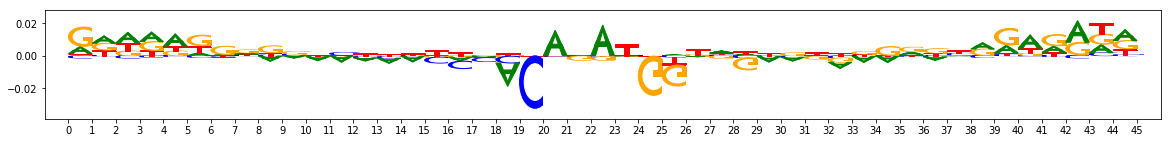

Task 2 hypothetical scores:


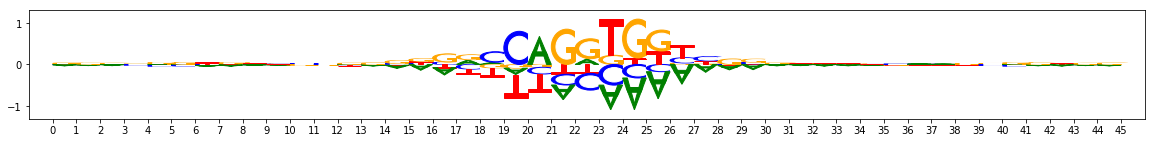

Task 2 actual importance scores:


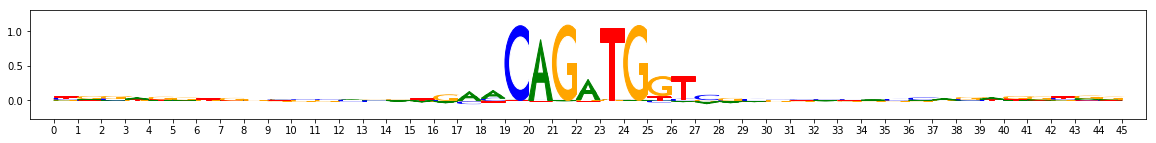

onehot, fwd


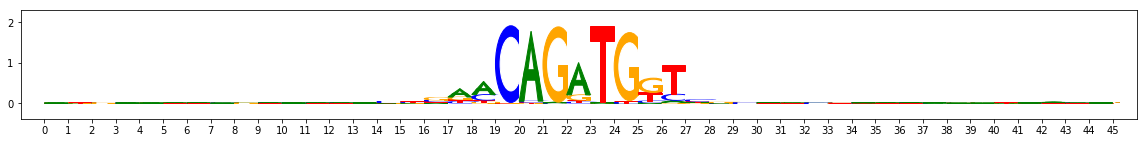

metacluster_1
activity pattern: [1 1 0]
metacluster_1 pattern_0
total seqlets: 480
activations


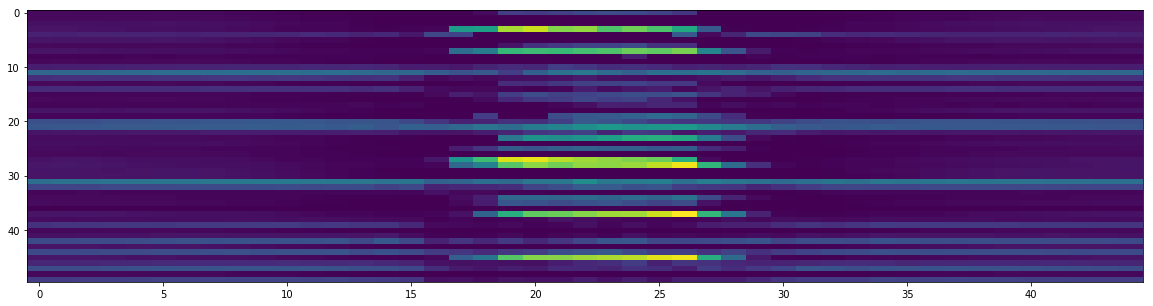

Task 0 hypothetical scores:


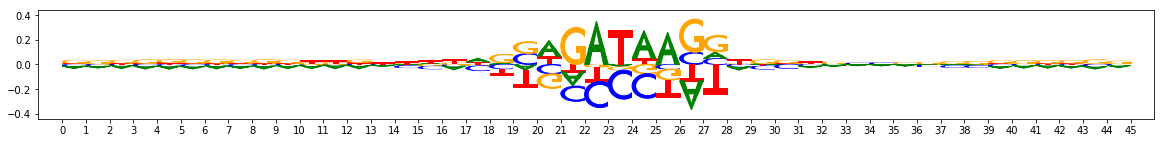

Task 0 actual importance scores:


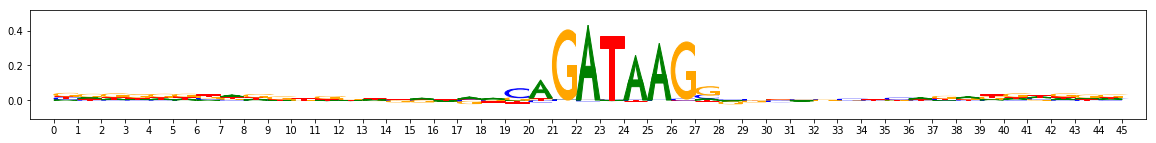

Task 1 hypothetical scores:


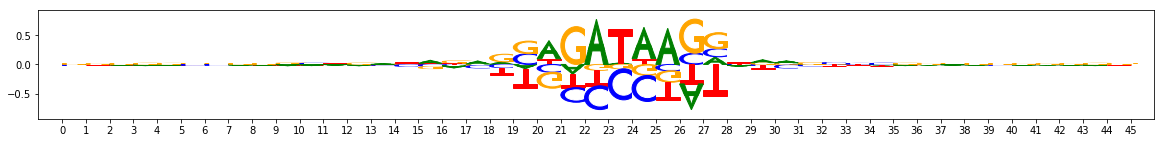

Task 1 actual importance scores:


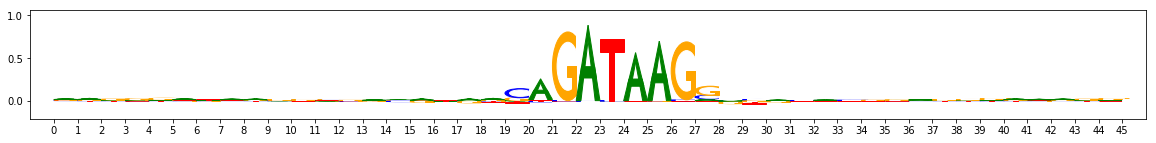

Task 2 hypothetical scores:


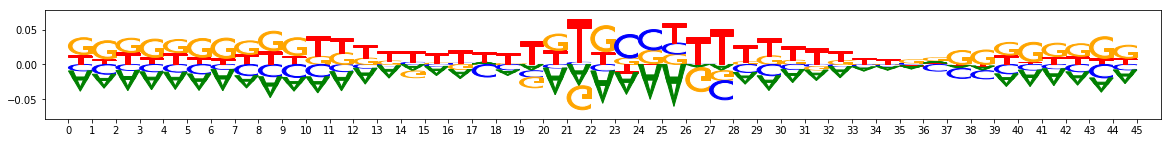

Task 2 actual importance scores:


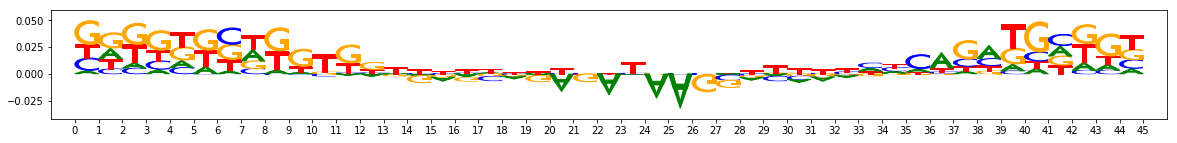

onehot, fwd


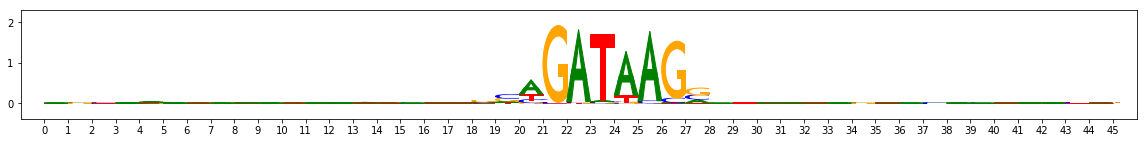

metacluster_2
activity pattern: [1 1 1]
metacluster_2 pattern_0
total seqlets: 167
activations


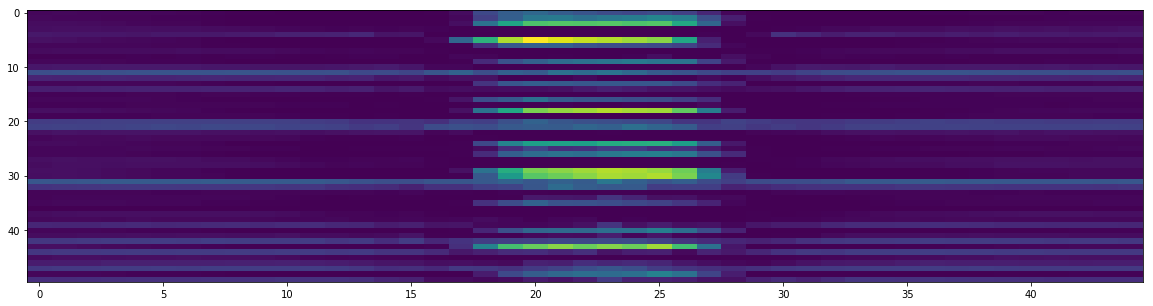

Task 0 hypothetical scores:


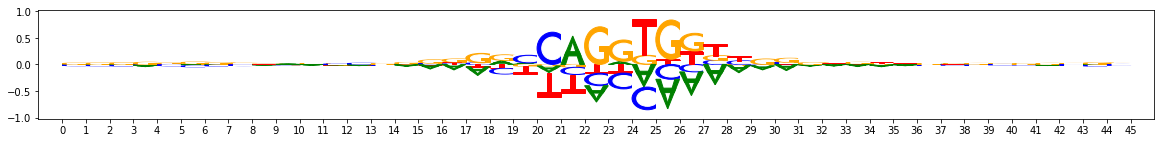

Task 0 actual importance scores:


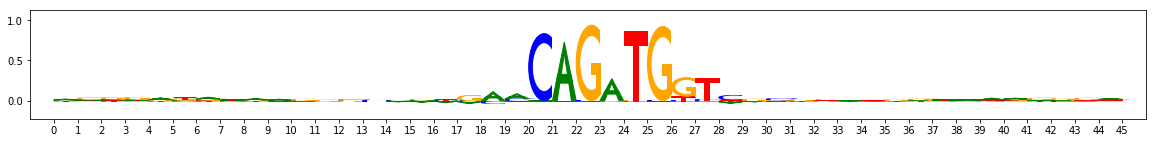

Task 1 hypothetical scores:


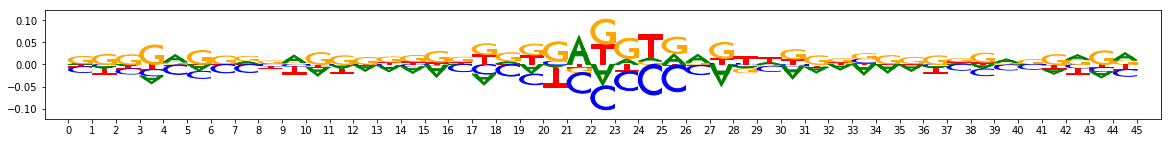

Task 1 actual importance scores:


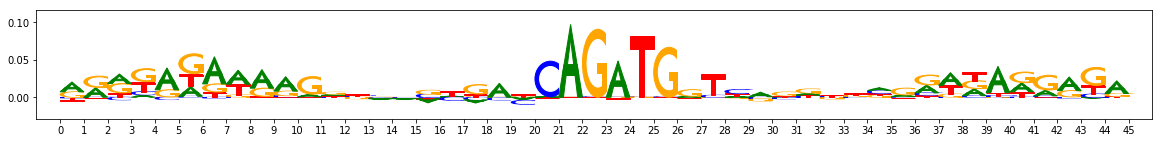

Task 2 hypothetical scores:


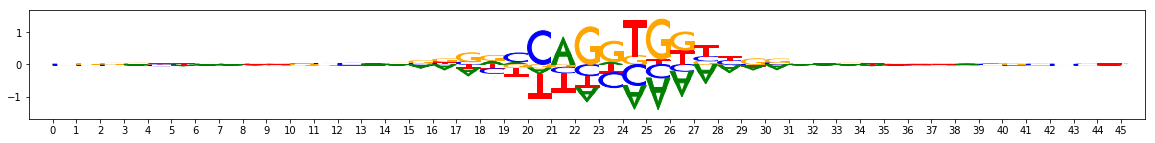

Task 2 actual importance scores:


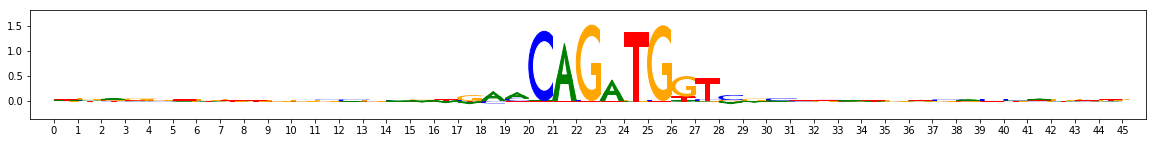

onehot, fwd


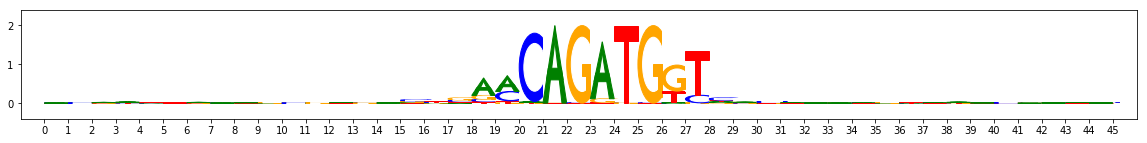

metacluster_2 pattern_1
total seqlets: 73
activations


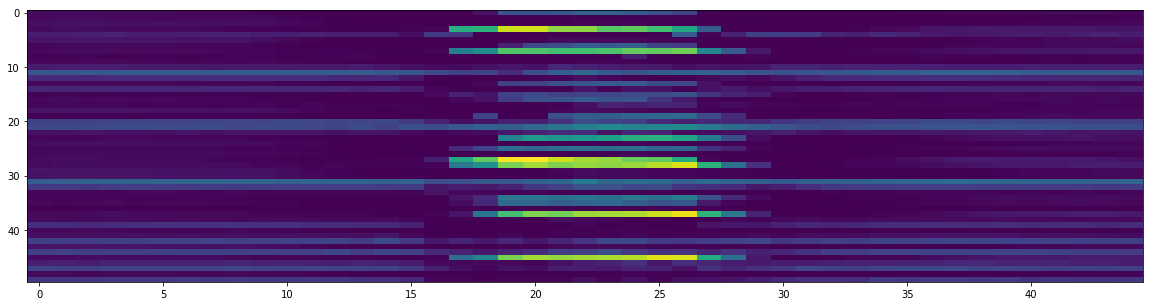

Task 0 hypothetical scores:


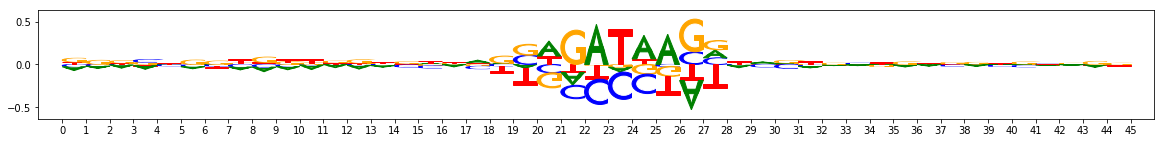

Task 0 actual importance scores:


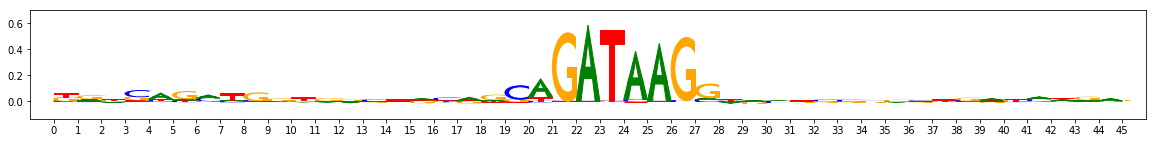

Task 1 hypothetical scores:


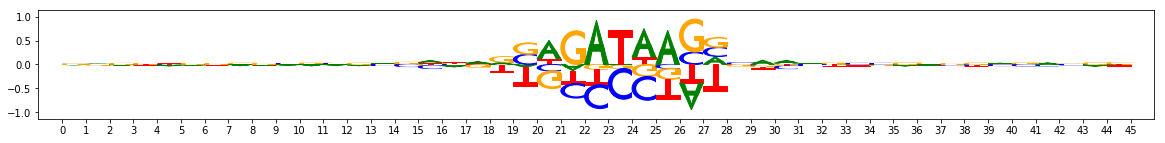

Task 1 actual importance scores:


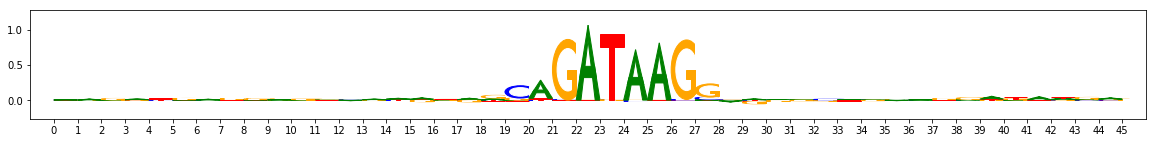

Task 2 hypothetical scores:


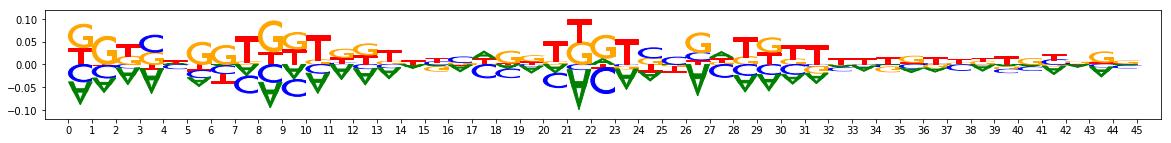

Task 2 actual importance scores:


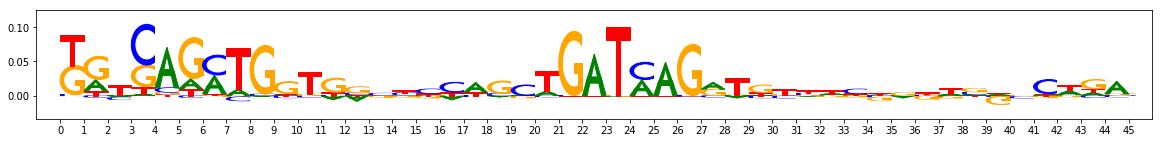

onehot, fwd


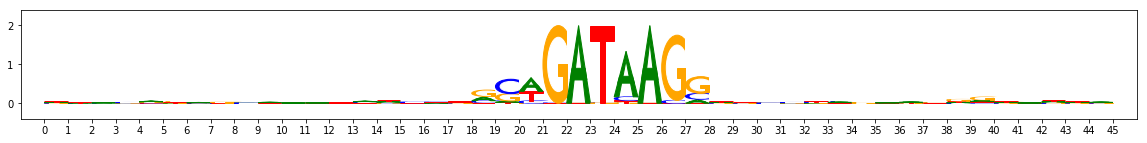

metacluster_3
activity pattern: [ 0  1 -1]
metacluster_3 pattern_0
total seqlets: 98
activations


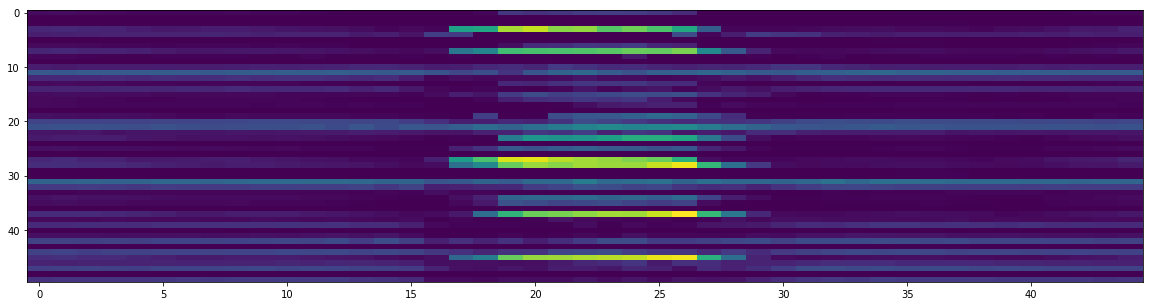

Task 0 hypothetical scores:


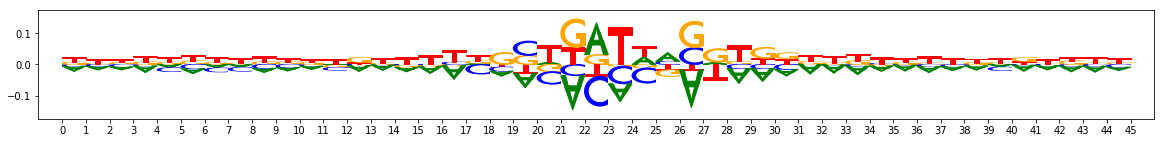

Task 0 actual importance scores:


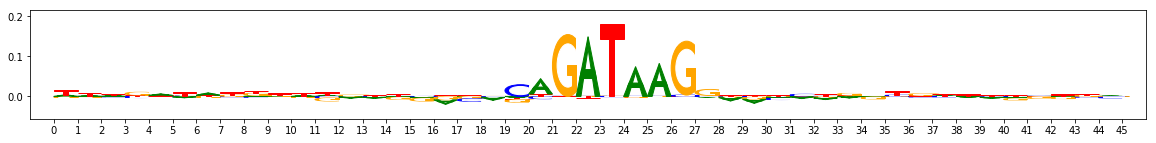

Task 1 hypothetical scores:


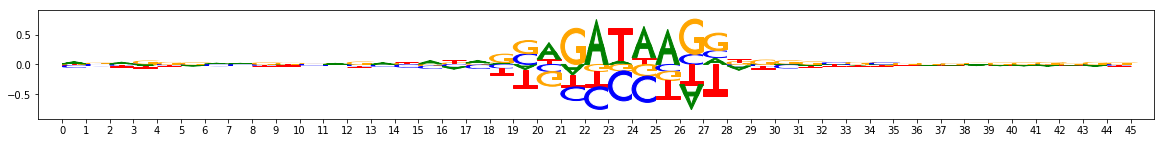

Task 1 actual importance scores:


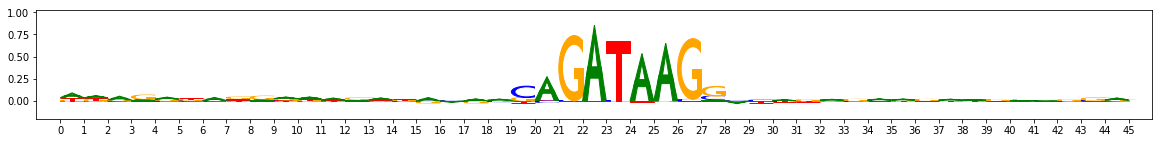

Task 2 hypothetical scores:


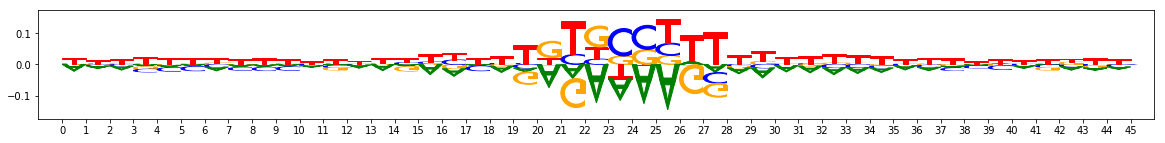

Task 2 actual importance scores:


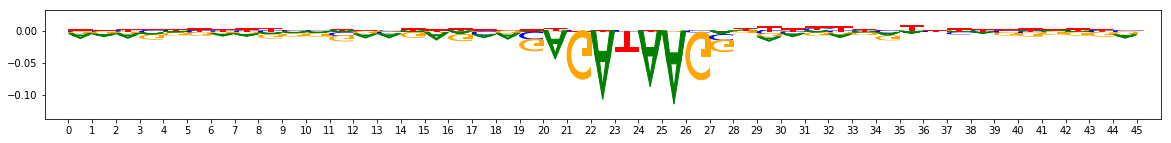

onehot, fwd


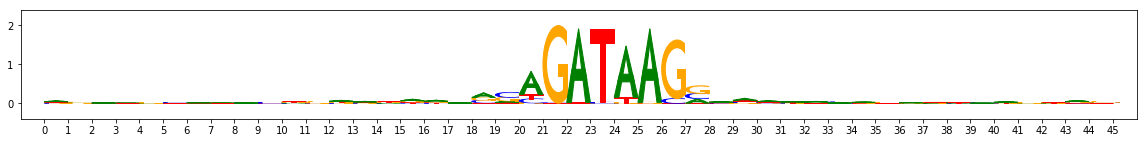

metacluster_4
activity pattern: [0 1 0]
No motifs found for this activity pattern
metacluster_5
activity pattern: [ 0  0 -1]
No motifs found for this activity pattern


In [19]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("activations")
        fig, ax = plt.subplots(figsize=(20, 5))
        ax.imshow(np.array(pattern["activations"]["fwd"]).transpose(1,0))
        ax.set_aspect('auto')
        plt.show()
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("Task 1 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        print("Task 1 actual importance scores:")
        viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        print("Task 2 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        print("Task 2 actual importance scores:")
        viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd")# and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        #viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
        #                                                background=background)) 
        
hdf5_results.close()